# CIFAR-10 Calibration Shift Detection

**Problem:** A pretrained classifier is deployed on CIFAR-10 test images. After some time, the input distribution shifts to CIFAR-10-C (corrupted images). The model continues to produce confidence scores, but they no longer reflect true accuracy—the model is *miscalibrated*.

**Solution:** PITMonitor watches the model's predicted probabilities against true labels in real-time. It detects when the probability integral transform (PIT) values deviate from uniformity, triggering an alarm without needing manual thresholds or labels ahead of time.

**This Demo:** We train an MLP classifier on CIFAR-10, then stream it CIFAR-10-C-corrupted images. PITMonitor detects the miscalibration shift and fires an alarm.

### Imports & Config

In [25]:
from __future__ import annotations

import pickle
import warnings
import time as timer
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from pitmon import PITMonitor

In [26]:
# Configuration Constants
SEED = 0
DATA_DIR = Path("./data")

# Demo 1: Single Detection Parameters
TRAIN_SIZE = 15_000
N_STABLE = 500
N_SHIFTED = 500
CORRUPTION = "gaussian_noise"
SEVERITY = 3

# PITMonitor Parameters
ALPHA = 0.05
N_BINS = 10

# Demo 2: Power Analysis Parameters
ALPHA_POWER = 0.05
N_STABLE_POWER = 300
N_SHIFTED_POWER = 300
N_TRIALS_H0_PER_SEVERITY = 100
N_TRIALS_H1_PER_SEVERITY = 100
SEVERITY_LEVELS = [1, 2, 3, 4, 5]

# Initialize RNG
rng = np.random.default_rng(SEED)

In [27]:
VERBOSE_DEMO = True


def log(message: str = "") -> None:
    if VERBOSE_DEMO:
        print(message)

### Helper Functions

In [28]:
@dataclass
class DetectionResult:
    alarm_fired: bool
    alarm_time: int | None
    detection_delay: int | None
    final_evidence: float


def _load_cifar_batch(batch_file: Path) -> tuple[np.ndarray, np.ndarray]:
    with open(batch_file, "rb") as f:
        payload = pickle.load(f, encoding="bytes")
    x = payload[b"data"]
    y = np.array(payload[b"labels"], dtype=np.int64)
    return x, y


def load_cifar10_train_test(
    data_dir: Path,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Load CIFAR-10 training and test sets."""
    root = data_dir / "CIFAR-10"
    if not root.exists():
        raise FileNotFoundError(f"Missing CIFAR-10 directory: {root}")

    x_train_all, y_train_all = [], []
    for i in range(1, 6):
        x_i, y_i = _load_cifar_batch(root / f"data_batch_{i}")
        x_train_all.append(x_i)
        y_train_all.append(y_i)

    x_train = np.vstack(x_train_all).astype(np.float32) / 255.0
    y_train = np.concatenate(y_train_all)
    x_test, y_test = _load_cifar_batch(root / "test_batch")
    x_test = x_test.astype(np.float32) / 255.0
    return x_train, y_train, x_test, y_test


def load_cifar10c_corruption(
    data_dir: Path, corruption: str, severity: int
) -> tuple[np.ndarray, np.ndarray]:
    """Load CIFAR-10-C corrupted images for a specific corruption type and severity."""
    if not 1 <= severity <= 5:
        raise ValueError("severity must be in {1,2,3,4,5}")

    root = data_dir / "CIFAR-10-C"
    if not root.exists():
        raise FileNotFoundError(f"Missing CIFAR-10-C directory: {root}")

    x_all = np.load(root / f"{corruption}.npy")
    y_all = np.load(root / "labels.npy")

    n_per_severity = 10_000
    start = (severity - 1) * n_per_severity
    end = severity * n_per_severity
    x = x_all[start:end].reshape(n_per_severity, -1).astype(np.float32) / 255.0
    y = y_all[start:end].astype(np.int64)
    return x, y


def sanitize_probabilities(probs: np.ndarray) -> np.ndarray:
    """Clean invalid probability values and ensure proper distribution."""
    probs = np.array(probs, dtype=np.float64, copy=True)
    probs = np.nan_to_num(probs, nan=0.0, posinf=0.0, neginf=0.0)

    row_sums = probs.sum(axis=1, keepdims=True)
    invalid_rows = ~np.isfinite(row_sums[:, 0]) | (row_sums[:, 0] <= 0.0)
    if np.any(invalid_rows):
        probs[invalid_rows] = 1.0 / probs.shape[1]
        row_sums = probs.sum(axis=1, keepdims=True)

    probs /= row_sums
    return probs.astype(np.float32)


def predict_proba_safe(
    clf: MLPClassifier, x: np.ndarray, scaler: StandardScaler
) -> np.ndarray:
    """Get predicted probabilities with safety checks."""
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        probs = clf.predict_proba(scaler.transform(x))
    return sanitize_probabilities(probs)


def compute_classification_pits(
    probs: np.ndarray, y_true: np.ndarray, rng: np.random.Generator
) -> np.ndarray:
    """
    Compute randomized PIT values for multi-class classification.

    For each sample with predicted probabilities [p_0, ..., p_{K-1}] and true class y,
    the PIT is computed as:
        PIT = sum_{j=0}^{y-1} p_j + U * p_y
    where U ~ Uniform(0,1).

    Under perfect calibration, these PITs are uniformly distributed on [0, 1].

    Parameters
    ----------
    probs : np.ndarray, shape (n_samples, n_classes)
        Predicted class probabilities
    y_true : np.ndarray, shape (n_samples,)
        True class labels (integers from 0 to n_classes-1)
    rng : np.random.Generator
        Random number generator for randomization

    Returns
    -------
    np.ndarray, shape (n_samples,)
        PIT values in [0, 1]
    """
    n_samples = len(y_true)
    pits = np.empty(n_samples, dtype=float)
    u = rng.random(n_samples)

    for i in range(n_samples):
        y = int(y_true[i])
        # Cumulative probability up to (but not including) the true class
        cum_prob = probs[i, :y].sum() if y > 0 else 0.0
        # Add randomized mass from the true class
        pits[i] = cum_prob + u[i] * probs[i, y]

    return np.clip(pits, 0.0, 1.0)

In [29]:
def run_pitmon_session(
    pits: np.ndarray,
    alpha: float,
    n_bins: int,
    n_stable: int,
) -> tuple[DetectionResult, np.ndarray, PITMonitor]:
    """Run PITMonitor on PIT stream and collect evidence trace."""
    monitor = PITMonitor(alpha=alpha, n_bins=n_bins)
    evidence_trace = np.empty(len(pits), dtype=float)

    for i, pit in enumerate(pits):
        update = monitor.update(pit)
        evidence_trace[i] = update.evidence

    alarm_time = monitor.alarm_time
    detection_delay = None
    if alarm_time is not None and alarm_time > n_stable:
        detection_delay = alarm_time - n_stable

    return (
        DetectionResult(
            alarm_fired=monitor.alarm_triggered,
            alarm_time=alarm_time,
            detection_delay=detection_delay,
            final_evidence=monitor.evidence,
        ),
        evidence_trace,
        monitor,
    )

In [30]:
def plot_pitmon_results(
    pred_labels: np.ndarray,
    true_labels: np.ndarray,
    pits: np.ndarray,
    evidence_trace: np.ndarray,
    true_shift_point: int,
    result: DetectionResult,
    monitor: PITMonitor,
    alpha: float,
    title: str,
) -> None:
    """Visualize PITMonitor detection results with 4 panels, using monitor's changepoint estimate."""
    t = np.arange(1, len(pits) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    fig.suptitle(title, fontsize=13, fontweight="bold")

    # Panel 1: Predicted classes colored by correctness
    ax = axes[0, 0]
    is_correct = pred_labels == true_labels
    point_colors = np.where(is_correct, "darkgreen", "crimson")
    ax.scatter(
        t,
        pred_labels,
        s=9,
        alpha=0.5,
        c=point_colors,
        label="Prediction (green=correct, red=wrong)",
        zorder=2,
    )

    ax.axvline(
        true_shift_point,
        color="red",
        ls=":",
        lw=1.5,
        alpha=0.8,
        label=f"True shift (t={true_shift_point})",
    )
    if result.alarm_fired and result.alarm_time is not None:
        ax.axvline(
            result.alarm_time,
            color="orange",
            ls="--",
            lw=1.5,
            label=f"Alarm (t={result.alarm_time})",
        )
    ax.set_ylabel("Predicted class", fontsize=11)
    ax.set_title("Predictions (Correct vs Wrong)", fontsize=11, fontweight="bold")
    ax.set_ylim(-0.5, 9.5)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)
    ax.set_xlim(left=0, right=len(t))

    # Panel 2: PIT scatter with rolling mean
    ax = axes[0, 1]
    colors = np.where(t <= true_shift_point, "steelblue", "crimson")
    ax.scatter(t, pits, s=5, alpha=0.4, c=colors)

    rolling_pit = np.convolve(pits, np.ones(30) / 30, mode="valid")
    ax.plot(
        np.arange(30, len(pits) + 1),
        rolling_pit,
        color="black",
        lw=1.5,
        alpha=0.6,
        label="Rolling mean (w=30)",
    )
    ax.axhline(0.5, color="gray", ls="--", lw=1, alpha=0.4)
    ax.axvline(true_shift_point, color="red", ls=":", lw=1.5, alpha=0.8)
    if result.alarm_fired and result.alarm_time is not None:
        ax.axvline(result.alarm_time, color="orange", ls="--", lw=1.5)
    ax.set_ylabel("PIT value", fontsize=11)
    ax.set_title("PIT Stream", fontsize=11, fontweight="bold")
    ax.set_ylim(-0.05, 1.05)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)
    ax.set_xlim(left=0, right=len(t))

    # Panel 3: Log-evidence trace with PITMonitor's changepoint
    ax = axes[1, 0]
    ax.semilogy(t, np.maximum(evidence_trace, 1e-10), color="steelblue", lw=2)
    threshold = 1 / alpha
    ax.axhline(
        threshold,
        color="crimson",
        ls="--",
        lw=2,
        label=f"Threshold (1/α = {threshold:.0f})",
    )
    ax.axvline(
        true_shift_point, color="red", ls=":", lw=1.5, alpha=0.8, label="True shift"
    )

    # Use PITMonitor's built-in changepoint estimate
    try:
        summary = monitor.summary()
        est_cp = summary.get("changepoint")
        if est_cp:
            ax.axvline(
                est_cp,
                color="green",
                ls="--",
                lw=1.5,
                alpha=0.7,
                label=f"Est. changepoint (t≈{est_cp})",
            )
    except:
        pass  # Fallback if summary not available

    if result.alarm_fired and result.alarm_time is not None:
        ax.axvline(
            result.alarm_time,
            color="orange",
            ls="--",
            lw=2,
            label=f"Alarm (t={result.alarm_time})",
        )
    ax.set_ylabel("Log-evidence", fontsize=11)
    ax.set_xlabel("Observation", fontsize=11)
    ax.set_title("PITMonitor Evidence", fontsize=11, fontweight="bold")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2, which="both")
    ax.set_xlim(left=0, right=len(t))

    # Panel 4: PIT distributions
    ax = axes[1, 1]
    hist_bins = np.linspace(0, 1, 21)
    ax.hist(
        pits[: true_shift_point - 1],
        bins=hist_bins,
        density=True,
        alpha=0.5,
        color="steelblue",
        edgecolor="white",
        label="Pre-shift",
    )
    ax.hist(
        pits[true_shift_point - 1 :],
        bins=hist_bins,
        density=True,
        alpha=0.5,
        color="crimson",
        edgecolor="white",
        label="Post-shift",
    )
    ax.axhline(1.0, color="black", ls="--", lw=1.5, label="Ideal (Uniform)")
    ax.set_xlabel("PIT value", fontsize=11)
    ax.set_ylabel("Density", fontsize=11)
    ax.set_title("PIT Distributions", fontsize=11, fontweight="bold")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

## Demo 1: Single Detection Run

Track a classifier as its input distribution shifts from clean CIFAR-10 to corrupted CIFAR-10-C.

#### Step 1: Load Data

In [31]:
log("Step 1: Load CIFAR-10 and CIFAR-10-C")

x_train, y_train, x_test, y_test = load_cifar10_train_test(DATA_DIR)
x_corr, y_corr = load_cifar10c_corruption(DATA_DIR, CORRUPTION, SEVERITY)

log(f"CIFAR-10 train: {x_train.shape}")
log(f"CIFAR-10 test: {x_test.shape}")
log(f"CIFAR-10-C: {x_corr.shape} (corruption={CORRUPTION}, severity={SEVERITY})")

# Validation
if TRAIN_SIZE > len(x_train):
    raise ValueError(f"TRAIN_SIZE={TRAIN_SIZE} exceeds available {len(x_train)}")
if N_STABLE > len(x_test):
    raise ValueError(f"N_STABLE={N_STABLE} exceeds test set {len(x_test)}")
if N_SHIFTED > len(x_corr):
    raise ValueError(f"N_SHIFTED={N_SHIFTED} exceeds corrupted {len(x_corr)}")

# Sample subsets
train_idx = rng.choice(len(x_train), size=TRAIN_SIZE, replace=False)
x_train_sub = x_train[train_idx]
y_train_sub = y_train[train_idx]

stable_idx = rng.choice(len(x_test), size=N_STABLE, replace=False)
shifted_idx = rng.choice(len(x_corr), size=N_SHIFTED, replace=False)
x_stable = x_test[stable_idx]
y_stable = y_test[stable_idx]
x_shifted = x_corr[shifted_idx]
y_shifted = y_corr[shifted_idx]

log(
    f"Config | train={TRAIN_SIZE:,}, stable={N_STABLE:,}, shifted={N_SHIFTED:,}, "
    f"alpha={ALPHA}, bins={N_BINS}"
)

Step 1: Load CIFAR-10 and CIFAR-10-C
CIFAR-10 train: (50000, 3072)
CIFAR-10 test: (10000, 3072)
CIFAR-10-C: (10000, 3072) (corruption=gaussian_noise, severity=3)
Config | train=15,000, stable=500, shifted=500, alpha=0.05, bins=10


#### Step 2: Train Model

In [32]:
log("Step 2: Train neural network on CIFAR-10")

scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train_sub)

clf = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu",
    solver="adam",
    max_iter=800,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=SEED,
    learning_rate_init=0.001,
)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf.fit(x_train_s, y_train_sub)

train_acc = clf.score(x_train_s, y_train_sub)
log(f"Training accuracy: {train_acc:.4f}")

Step 2: Train neural network on CIFAR-10
Training accuracy: 0.6580


#### Step 3: Run Detection

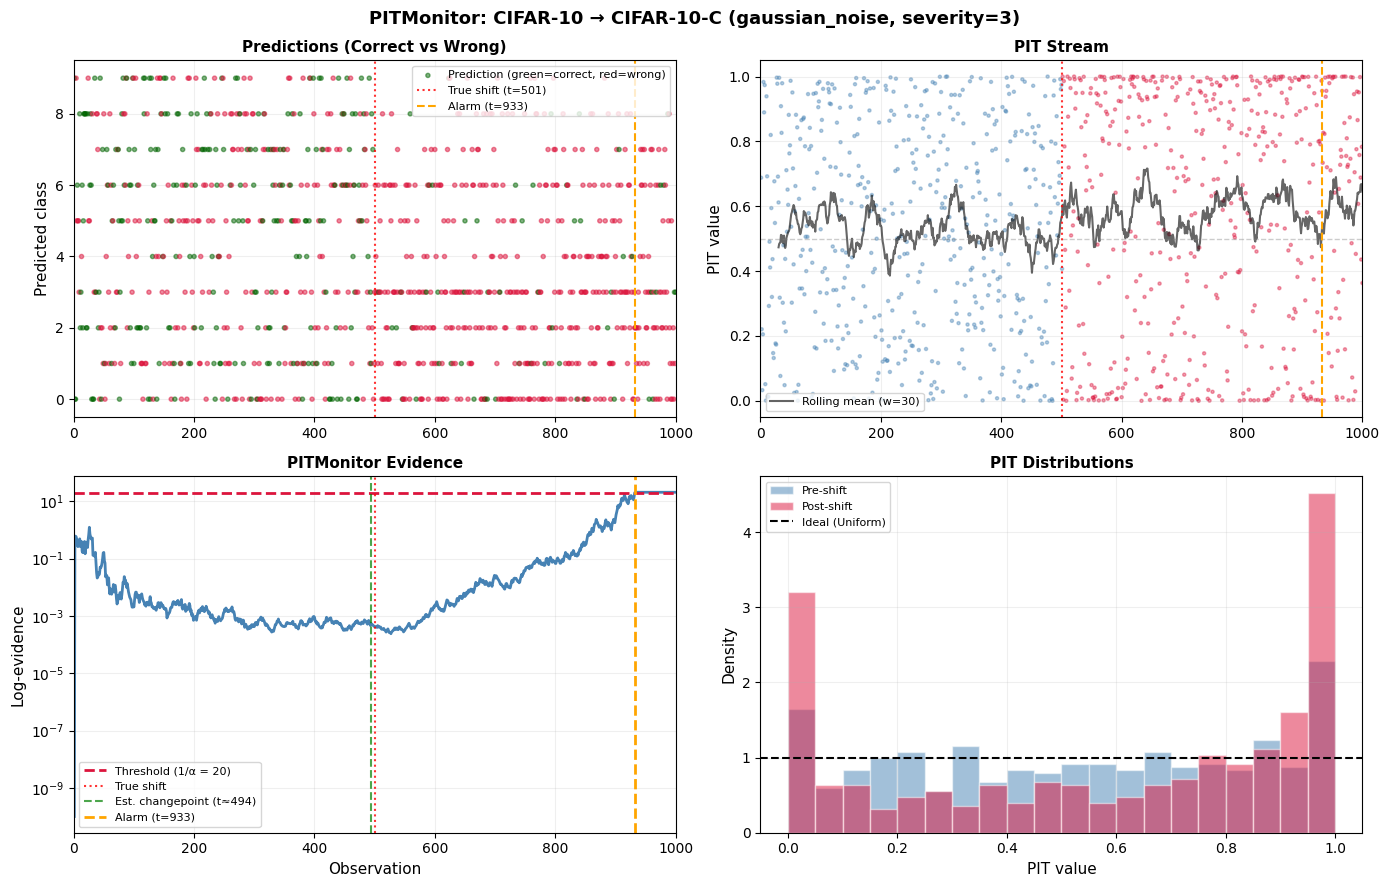

In [33]:
# Combine stable + shifted streams
x_stream = np.vstack([x_stable, x_shifted])
y_stream = np.concatenate([y_stable, y_shifted])
true_shift_point = N_STABLE + 1

# Get predictions
probs = clf.predict_proba(scaler.transform(x_stream))
pred = probs.argmax(axis=1)

# Compute PITs using proper multi-class formula
rng_demo = np.random.default_rng(SEED)
pits = compute_classification_pits(probs, y_stream, rng_demo)

# Run PITMonitor
result, evidence_trace, monitor = run_pitmon_session(pits, ALPHA, N_BINS, N_STABLE)

# Visualize
plot_pitmon_results(
    pred,
    y_stream,
    pits,
    evidence_trace,
    true_shift_point,
    result,
    monitor,
    ALPHA,
    f"PITMonitor: CIFAR-10 → CIFAR-10-C ({CORRUPTION}, severity={SEVERITY})",
)

## Demo 2: Power Analysis

Evaluate PITMonitor's detection reliability across corruption severity levels:
- **H₀ Validation:** False Positive Rate control (clean → clean)
- **H₁ Power:** True Positive Rate vs corruption severity (clean → corrupted)
- **Detection Latency:** Time to alarm across severity levels

In [34]:
def summarize_power_trials(trials: list[dict], n_trials: int) -> dict:
    """Aggregate trial-level monitoring results into power statistics."""
    n_alarms = sum(t["alarm_fired"] for t in trials)
    n_false = sum(t["false_alarm"] for t in trials)
    n_detect = sum(1 for t in trials if t["alarm_fired"] and not t["false_alarm"])
    alarm_rate = n_alarms / n_trials
    false_rate = n_false / n_trials
    tpr = n_detect / n_trials

    delays = [t["detection_delay"] for t in trials if t["detection_delay"] is not None]
    median_delay = np.median(delays) if delays else float("nan")
    mean_delay = np.mean(delays) if delays else float("nan")

    def wilson_ci(k: int, n: int, z: float = 1.96) -> tuple[float, float]:
        if n <= 0:
            return float("nan"), float("nan")
        p_hat = k / n
        denom = 1 + z**2 / n
        center = (p_hat + z**2 / (2 * n)) / denom
        radius = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * n)) / n) / denom
        return float(max(0.0, center - radius)), float(min(1.0, center + radius))

    tpr_ci_low, tpr_ci_high = wilson_ci(n_detect, n_trials)
    fpr_ci_low, fpr_ci_high = wilson_ci(n_false, n_trials)

    return {
        "n_trials": n_trials,
        "n_alarms": n_alarms,
        "n_false": n_false,
        "n_detect": n_detect,
        "alarm_rate": alarm_rate,
        "false_alarm_rate": false_rate,
        "tpr": tpr,
        "tpr_ci_low": tpr_ci_low,
        "tpr_ci_high": tpr_ci_high,
        "fpr_ci_low": fpr_ci_low,
        "fpr_ci_high": fpr_ci_high,
        "median_delay": median_delay,
        "mean_delay": mean_delay,
        "delays": delays,
        "evidences": [t["final_evidence"] for t in trials],
    }


def run_power_trial(
    clf_trained,
    scaler_trained,
    x_stable,
    y_stable,
    x_shifted,
    y_shifted,
    alpha: float = 0.05,
    n_bins: int = 10,
    trial_seed: int = None,
) -> dict:
    """
    Run one CIFAR monitoring trial using a pre-trained classifier.

    This avoids retraining the classifier for every trial, dramatically
    speeding up power analysis execution.

    Parameters
    ----------
    clf_trained : MLPClassifier
        Pre-trained classifier to use for predictions
    scaler_trained : StandardScaler
        Pre-fitted scaler matching the classifier

    Returns
    -------
    dict
        Standard trial summary from PITMonitor's built-in trial_summary method.
    """
    # Combine streams
    x_all = np.vstack([x_stable, x_shifted])
    y_all = np.concatenate([y_stable, y_shifted])
    n_stable_local = len(y_stable)

    # Get predictions using pre-trained classifier
    probs = predict_proba_safe(clf_trained, x_all, scaler_trained)

    # Compute PITs using proper multi-class formula
    rng_trial = np.random.default_rng(trial_seed)
    pits = compute_classification_pits(probs, y_all, rng_trial)

    # Run monitoring using PITMonitor's built-in methods
    monitor = PITMonitor(alpha=alpha, n_bins=n_bins)
    monitor.update_many(pits, stop_on_alarm=True)

    # Use PITMonitor's built-in trial summary (includes proper FPR logic)
    return monitor.trial_summary(n_stable_local)

In [35]:
log("Power analysis: H₀ validation + H₁ detection rate")
log("Evaluating FPR control and TPR across corruption severities")

log("Phase 1: H₀ validation (clean → clean)")

h0_results_by_severity = {}
t0_global = timer.time()

# H₀: Train ONE classifier on clean CIFAR-10, then evaluate on independent test splits
# This eliminates network randomness as a source of false alarms
log("Training baseline classifier for H₀ validation...")
sc_h0 = StandardScaler()
x_train_s = sc_h0.fit_transform(x_train_sub)

clf_h0 = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu",
    solver="adam",
    max_iter=800,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=SEED,
    learning_rate_init=0.001,
)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf_h0.fit(x_train_s, y_train_sub)

# Run H₀ trials using the same trained model on different clean test splits
h0_trials = []
for trial_idx in range(N_TRIALS_H0_PER_SEVERITY):
    rng_h0 = np.random.RandomState(SEED + 50000 + trial_idx)
    stable_idx_h0 = rng_h0.choice(len(x_test), size=N_STABLE_POWER, replace=False)
    shifted_idx_h0 = rng_h0.choice(len(x_test), size=N_SHIFTED_POWER, replace=False)

    x_stable_h0 = x_test[stable_idx_h0]
    y_stable_h0 = y_test[stable_idx_h0]
    x_shifted_h0 = x_test[shifted_idx_h0]
    y_shifted_h0 = y_test[shifted_idx_h0]

    # Combine streams
    x_all = np.vstack([x_stable_h0, x_shifted_h0])
    y_all = np.concatenate([y_stable_h0, y_shifted_h0])
    n_stable_local = len(y_stable_h0)

    # Predict using the SAME trained model
    probs = predict_proba_safe(clf_h0, x_all, sc_h0)

    # Compute PITs using proper multi-class formula
    rng_trial = np.random.default_rng(SEED + 50000 + trial_idx)
    pits = compute_classification_pits(probs, y_all, rng_trial)

    # Run monitoring
    monitor = PITMonitor(alpha=ALPHA_POWER, n_bins=N_BINS)
    monitor.update_many(pits, stop_on_alarm=True)

    alarm_fired = monitor.alarm_time is not None
    alarm_time = monitor.alarm_time
    false_alarm = alarm_fired and alarm_time <= n_stable_local
    detection_delay = None
    if alarm_fired and alarm_time > n_stable_local:
        detection_delay = alarm_time - n_stable_local

    h0_trials.append(
        {
            "alarm_fired": alarm_fired,
            "alarm_time": alarm_time,
            "detection_delay": detection_delay,
            "final_evidence": float(monitor.evidence),
            "false_alarm": false_alarm,
        }
    )

h0_summary = summarize_power_trials(h0_trials, n_trials=N_TRIALS_H0_PER_SEVERITY)

# Replicate H₀ results across all severity levels (H₀ doesn't depend on severity)
for severity_level in SEVERITY_LEVELS:
    h0_results_by_severity[severity_level] = h0_summary
    elapsed = timer.time() - t0_global
    result = h0_results_by_severity[severity_level]
    status = (
        "✓ conservative"
        if result["fpr_ci_high"] <= ALPHA_POWER
        else "△ inconclusive (increase trials)"
    )
    log(
        f"Severity {severity_level}: H₀ FPR={result['false_alarm_rate']:>5.1%} "
        f"95% CI=[{result['fpr_ci_low']:.1%}, {result['fpr_ci_high']:.1%}] "
        f"{status} [{elapsed:>5.0f}s]"
    )

log("Phase 2: H₁ analysis (clean-trained model vs corrupted stream)")

power_results_by_severity = {}

for severity_level in SEVERITY_LEVELS:
    # Load CIFAR-10-C at this severity
    cifar_c_path = DATA_DIR / "CIFAR-10-C" / f"{CORRUPTION}.npy"
    labels_path = DATA_DIR / "CIFAR-10-C" / "labels.npy"

    x_c_full = np.load(cifar_c_path)
    y_c_full = np.load(labels_path)

    start_idx = (severity_level - 1) * 10000
    end_idx = severity_level * 10000
    x_c_severity = x_c_full[start_idx:end_idx]
    y_c_severity = y_c_full[start_idx:end_idx]

    if x_c_severity.ndim == 4:
        x_c_severity = x_c_severity.reshape(len(x_c_severity), -1)

    # H₁: Test the clean-trained classifier (clf_h0) against corrupted data
    h1_trials_sev = []
    for trial_idx in range(N_TRIALS_H1_PER_SEVERITY):
        rng = np.random.RandomState(SEED + severity_level * 1000 + trial_idx)
        stable_idx = rng.choice(len(x_test), size=N_STABLE_POWER, replace=False)
        shifted_idx = rng.choice(len(x_c_severity), size=N_SHIFTED_POWER, replace=False)

        x_stable_h1 = x_test[stable_idx]
        y_stable_h1 = y_test[stable_idx]
        x_shifted_h1 = x_c_severity[shifted_idx]
        y_shifted_h1 = y_c_severity[shifted_idx]

        trial_result = run_power_trial(
            clf_h0,
            sc_h0,
            x_stable_h1,
            y_stable_h1,
            x_shifted_h1,
            y_shifted_h1,
            alpha=ALPHA_POWER,
            n_bins=N_BINS,
            trial_seed=SEED + severity_level * 1000 + trial_idx,
        )
        h1_trials_sev.append(trial_result)

    power_results_by_severity[severity_level] = summarize_power_trials(
        h1_trials_sev, n_trials=N_TRIALS_H1_PER_SEVERITY
    )
    elapsed = timer.time() - t0_global
    stats = power_results_by_severity[severity_level]
    log(
        f"Severity {severity_level}: TPR={stats['tpr']:>5.1%} "
        f"95% CI=[{stats['tpr_ci_low']:.1%}, {stats['tpr_ci_high']:.1%}] "
        f"Delay={stats['median_delay']:>6.0f} [{elapsed:>5.0f}s]"
    )

print("Summary by severity")
print(
    f"{'Severity':>8s}  {'H₀ FPR [95% CI]':>24s}  {'H₁ TPR [95% CI]':>24s}  {'Median Delay':>12s}"
)
for severity_level in SEVERITY_LEVELS:
    h0_r = h0_results_by_severity[severity_level]
    h1_r = power_results_by_severity[severity_level]
    print(
        f"{severity_level:>8d}  "
        f"{h0_r['false_alarm_rate']:>6.1%} [{h0_r['fpr_ci_low']:.1%}, {h0_r['fpr_ci_high']:.1%}]  "
        f"{h1_r['tpr']:>6.1%} [{h1_r['tpr_ci_low']:.1%}, {h1_r['tpr_ci_high']:.1%}]  "
        f"{h1_r['median_delay']:>12.0f}"
    )
print(f"Total time: {timer.time() - t0_global:.1f}s")

Power analysis: H₀ validation + H₁ detection rate
Evaluating FPR control and TPR across corruption severities
Phase 1: H₀ validation (clean → clean)
Training baseline classifier for H₀ validation...
Severity 1: H₀ FPR= 5.0% 95% CI=[2.2%, 11.2%] △ inconclusive (increase trials) [    4s]
Severity 2: H₀ FPR= 5.0% 95% CI=[2.2%, 11.2%] △ inconclusive (increase trials) [    4s]
Severity 3: H₀ FPR= 5.0% 95% CI=[2.2%, 11.2%] △ inconclusive (increase trials) [    4s]
Severity 4: H₀ FPR= 5.0% 95% CI=[2.2%, 11.2%] △ inconclusive (increase trials) [    4s]
Severity 5: H₀ FPR= 5.0% 95% CI=[2.2%, 11.2%] △ inconclusive (increase trials) [    4s]
Phase 2: H₁ analysis (clean-trained model vs corrupted stream)
Severity 1: TPR=98.0% 95% CI=[93.0%, 99.4%] Delay=    46 [    7s]
Severity 2: TPR=99.0% 95% CI=[94.6%, 99.8%] Delay=    44 [    9s]
Severity 3: TPR=97.0% 95% CI=[91.5%, 99.0%] Delay=    43 [   12s]
Severity 4: TPR=98.0% 95% CI=[93.0%, 99.4%] Delay=    46 [   14s]
Severity 5: TPR=97.0% 95% CI=[91.5

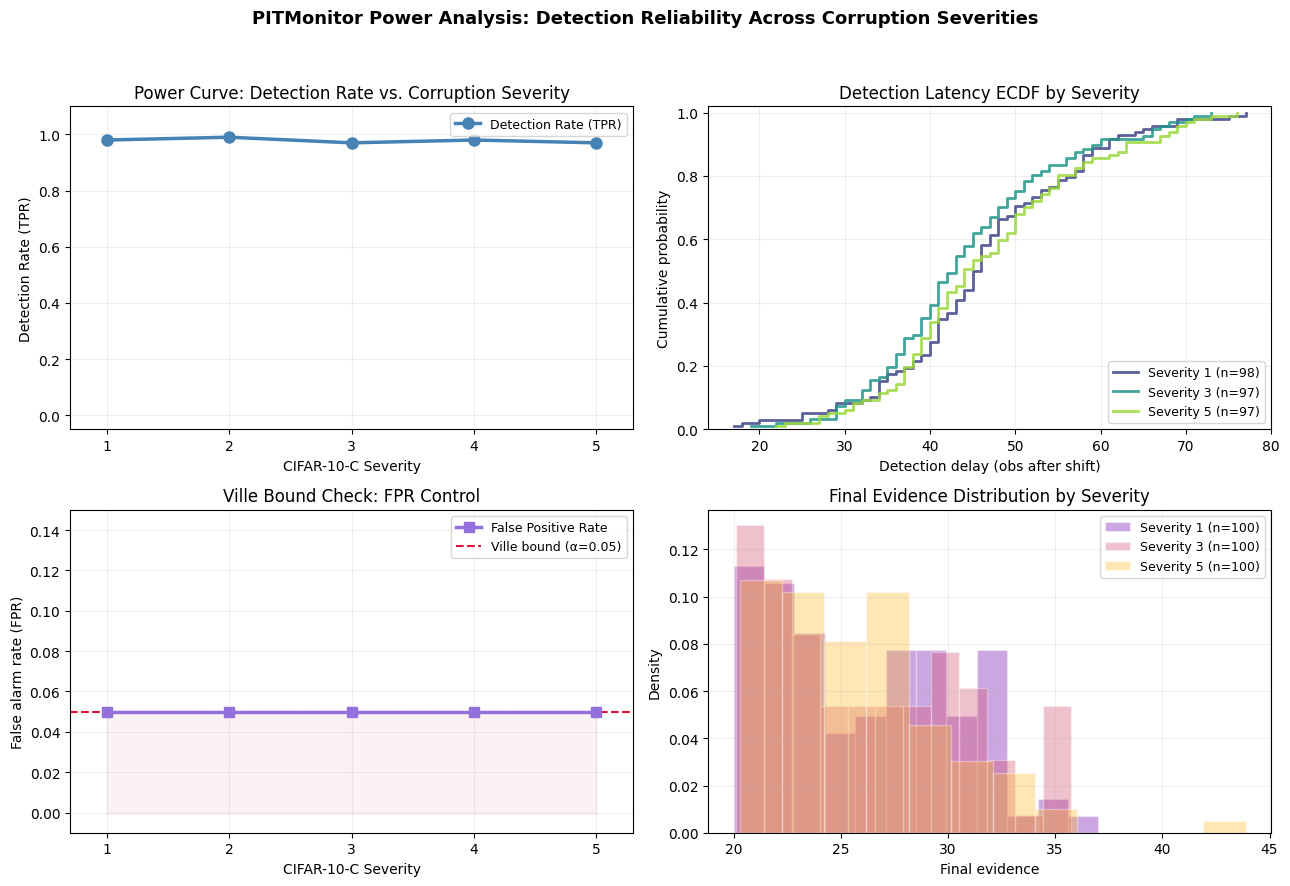

In [36]:
severity_list = list(SEVERITY_LEVELS)
h0_fprs = [h0_results_by_severity[sv]["false_alarm_rate"] for sv in SEVERITY_LEVELS]
h1_tprs = [power_results_by_severity[sv]["tpr"] for sv in SEVERITY_LEVELS]
h1_delays = [power_results_by_severity[sv]["median_delay"] for sv in SEVERITY_LEVELS]

fig2, axes2 = plt.subplots(2, 2, figsize=(13, 9))
fig2.suptitle(
    "PITMonitor Power Analysis: Detection Reliability Across Corruption Severities",
    fontsize=13,
    fontweight="bold",
    y=0.98,
)

# Panel 1: Power curve (H₁ TPR vs severity)
ax = axes2[0, 0]
ax.plot(
    severity_list,
    h1_tprs,
    "o-",
    color="steelblue",
    lw=2.5,
    markersize=8,
    label="Detection Rate (TPR)",
    zorder=3,
)
ax.set(
    xlabel="CIFAR-10-C Severity",
    ylabel="Detection Rate (TPR)",
    title="Power Curve: Detection Rate vs. Corruption Severity",
)
ax.set_ylim(-0.05, 1.1)
ax.set_xlim(min(severity_list) - 0.3, max(severity_list) + 0.3)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.2)

# Panel 2: Detection delay ECDF by severity
ax = axes2[0, 1]
selected_sev = [1, 3, 5]
colors_delay = plt.cm.viridis(np.linspace(0.2, 0.85, len(selected_sev)))

for severity_level, c in zip(selected_sev, colors_delay):
    if severity_level in power_results_by_severity:
        delays = np.asarray(
            power_results_by_severity[severity_level]["delays"], dtype=float
        )
        if delays.size > 0:
            delays_sorted = np.sort(delays)
            ecdf = np.arange(1, len(delays_sorted) + 1) / len(delays_sorted)
            ax.step(
                delays_sorted,
                ecdf,
                where="post",
                color=c,
                lw=2,
                alpha=0.85,
                label=f"Severity {severity_level} (n={len(delays)})",
            )

ax.set(
    xlabel="Detection delay (obs after shift)",
    ylabel="Cumulative probability",
    title="Detection Latency ECDF by Severity",
)
ax.set_ylim(0.0, 1.02)
ax.legend(fontsize=9, loc="lower right")
ax.grid(True, alpha=0.2)

# Panel 3: H₀ FPR control (Ville bound)
ax = axes2[1, 0]
ax.plot(
    severity_list,
    h0_fprs,
    "s-",
    color="mediumpurple",
    lw=2.5,
    markersize=7,
    zorder=3,
    label="False Positive Rate",
)
ax.axhline(
    ALPHA_POWER,
    color="crimson",
    ls="--",
    lw=1.5,
    label=f"Ville bound (α={ALPHA_POWER:.2f})",
)
ax.fill_between(
    severity_list,
    0,
    [ALPHA_POWER] * len(severity_list),
    color="crimson",
    alpha=0.06,
)

ax.set(
    xlabel="CIFAR-10-C Severity",
    ylabel="False alarm rate (FPR)",
    title="Ville Bound Check: FPR Control",
)
ax.set_ylim(-0.01, min(0.15, ALPHA_POWER * 3.0))
ax.set_xlim(min(severity_list) - 0.3, max(severity_list) + 0.3)
ax.legend(fontsize=9, loc="upper right")
ax.grid(True, alpha=0.2)

# Panel 4: Final evidence distribution by severity
ax = axes2[1, 1]
selected_ev_sev = [1, 3, 5]
colors_ev = plt.cm.plasma(np.linspace(0.2, 0.85, len(selected_ev_sev)))

for severity_level, c in zip(selected_ev_sev, colors_ev):
    if severity_level in power_results_by_severity:
        evidences = np.asarray(
            power_results_by_severity[severity_level]["evidences"], dtype=float
        )
        if evidences.size > 0:
            ax.hist(
                evidences,
                bins=12,
                density=True,
                alpha=0.35,
                color=c,
                edgecolor="white",
                label=f"Severity {severity_level} (n={len(evidences)})",
            )

ax.set(
    xlabel="Final evidence",
    ylabel="Density",
    title="Final Evidence Distribution by Severity",
)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()